In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import os
import process_observed_discharge as mQ
import glob
import pickle

#### Model Evaluation
Compare Q quantiles of individuals models to observations

In [3]:
with open("eval_stations_Q.pickle", "rb") as f:
    q_Obs = pickle.load(f)

#read validation stations (NSE>0
val_gdf = pd.read_csv('validation_stations_NSE_above_0.csv')

#Extract only stations in val_gdf
q_Obs = {k: v for k, v in q_Obs.items() if k in val_gdf['name'].values}

In [4]:
#Function to extract per station flow quantiles

def extract_flow_quantiles(q_model: pd.Series, q_obs: pd.Series, station_id: str):
    """
    Extract Q50 and Q90 for model vs. observed discharge at a given station.
    Returns a single-row DataFrame or None if too short.
    """
    #Firstly resample to monthly ends
    q_model_m = q_model.resample("ME").mean()
    q_obs_m = q_obs.resample("ME").mean()
    # If DataFrame, reduce to first column
    if isinstance(q_model_m, pd.DataFrame):
        q_model_m = q_model_m.iloc[:, 0]
    if isinstance(q_obs, pd.DataFrame):
        q_obs_m = q_obs_m.iloc[:, 0]

    # Align and drop NaNs
    q_quant = pd.concat([q_model_m, q_obs_m], axis=1)
    q_quant.columns = ["q_model", "q_obs"]
    q_quant = q_quant.dropna()

    if len(q_quant) > 12:  # at least 2 years of overlapping data
        print(f"Station {station_id}: {len(q_quant)} overlapping data points found.", end="\r")
        q50_model = np.nanpercentile(q_quant["q_model"].values, 50)
        q90_model = np.nanpercentile(q_quant["q_model"].values, 10)
        q50_obs   = np.nanpercentile(q_quant["q_obs"].values, 50)
        q90_obs   = np.nanpercentile(q_quant["q_obs"].values, 10)

        return pd.DataFrame(
            {
                "station": [station_id],
                "q50_model": [q50_model],
                "q90_model": [q90_model],
                "q50_obs": [q50_obs],
                "q90_obs": [q90_obs],
            }
        )
    else:
        print(f"Station {station_id}: skipped ({len(q_quant)} points only).", end="\r")
        return None

In [5]:
models = ["GFDL-ESM4", "IPSL-CM6A-LR", "MPI-ESM1-2-HR", "UKESM1-0-LL"]
canals = ['HACCOURT', 'Merendree_Afleidingskl Leie', 'Damme_Leopoldkl']

all_quantiles = {}

for model in models:
    sim_files = glob.glob(f"isimip_Q/{model}/Qrouted/*.csv")
    quantiles = []  # <-- collect per model

    for fpath in sim_files:
        station_name = os.path.splitext(os.path.basename(fpath))[0]

        if station_name not in q_Obs:
            continue  # skip stations without obs
        if station_name in canals:
            continue  # skip canal stations

        obs_Q = q_Obs[station_name]
        sim_Q = pd.read_csv(fpath, index_col=0, parse_dates=True)

        qn = extract_flow_quantiles(sim_Q, obs_Q, station_name)
        if qn is not None:
            qn["model"] = model
            quantiles.append(qn)

    if quantiles:  # <-- use the correct list
        quantiles_df = pd.concat(quantiles, ignore_index=True)
    else:
        quantiles_df = pd.DataFrame()

    all_quantiles[model] = quantiles_df


In [6]:
g_df = all_quantiles["GFDL-ESM4"]

#plt.scatter(g_df['q50_obs'], g_df['q50_model'], label='Q50', color='blue', alpha=0.6)

#1:1 line
max_val = max(g_df[['q50_obs', 'q50_model']].max().max(), g_df[['q90_obs', 'q90_model']].max().max())


Text(0.5, 33.000000000000014, 'Observed Discharge Q [m³/s]')

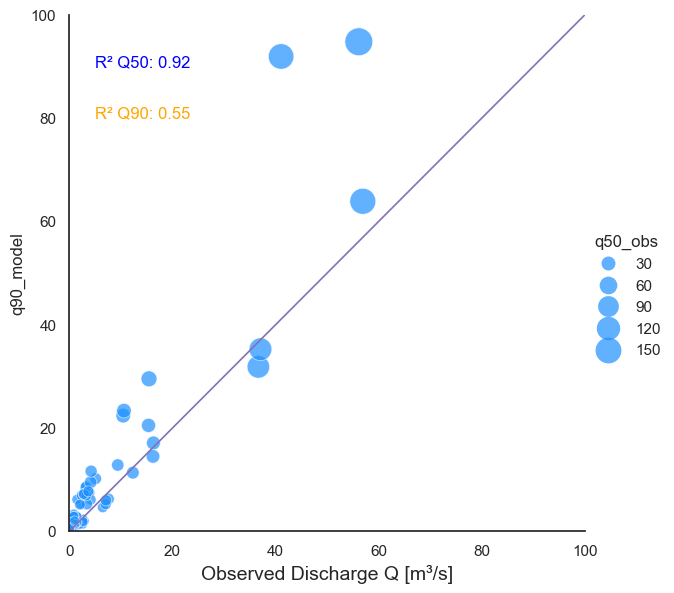

In [7]:
import seaborn as sns
#fig, ax = plt.subplots(figsize=(8, 8))
sns.set_theme(style="white")


# Plot miles per gallon against horsepower with other semantics
sns.relplot(x='q90_obs', y='q90_model', size="q50_obs",
            sizes=(40, 400), alpha=.7, color="dodgerblue",
            height=6, data=g_df)
#remove legend
plt.legend([],[], frameon=False)

max_val = max(g_df[['q90_obs', 'q90_model']].max().max(), g_df[['q90_obs', 'q90_model']].max().max())

#1:1 LINE   
plt.plot([0, 125], [0, 125], 'm', label='1:1 line', lw=1.2)

plt.xlim(0, 100)
plt.ylim(0, 100)

#calculate R^2
from sklearn.metrics import r2_score
r2_q50 = r2_score(g_df['q50_obs'], g_df['q50_model'])
r2_q90 = r2_score(g_df['q90_obs'], g_df['q90_model'])

plt.text(5, 90, f'R² Q50: {r2_q50:.2f}', fontsize=12, color='blue')
plt.text(5, 80, f'R² Q90: {r2_q90:.2f}', fontsize=12, color='orange')
plt.xlabel('Observed Discharge Q [m³/s]', fontsize=14)

#### Seasonal comparison of per-station Q

In [8]:
# Define seasons
season_map = {12: "DJF", 1: "DJF", 2: "DJF",
              3: "MAM", 4: "MAM", 5: "MAM",
              6: "JJA", 7: "JJA", 8: "JJA",
              9: "SON", 10: "SON", 11: "SON"}

# ts_season = sim_Q.groupby(sim_Q.index.month.map(season_map)).mean()
# obs_season = obs_Q.groupby(obs_Q.index.month.map(season_map)).mean()

for model in models:
    model_season=[]
    for season in ['DJF', 'MAM', 'JJA', 'SON']:
        sim_files = glob.glob(f"isimip_Q/{model}/Qrouted/*.csv")
        for fpath in sim_files:
            station_name = os.path.splitext(os.path.basename(fpath))[0]

            if station_name not in q_Obs:
                continue  # skip stations without obs
            if station_name in canals:
                continue  # skip canal stations

            obs_Q = q_Obs[station_name]
            sim_Q = pd.read_csv(fpath, index_col=0, parse_dates=True)

            ts_season = sim_Q.groupby(sim_Q.index.month.map(season_map)).mean()
            obs_season = obs_Q.groupby(obs_Q.index.month.map(season_map)).mean()

            model_season.append({
                'station': station_name,
                'season': season,
                'q_model': ts_season.loc[season].values[0],
                'q_obs': obs_season.loc[season].values[0]
            })


In [9]:
#dict to dataframe
model_season_df=pd.DataFrame(model_season)

Text(0.5, 1.0, 'Seasonal Discharge Comparison - UKESM1-0-LL')

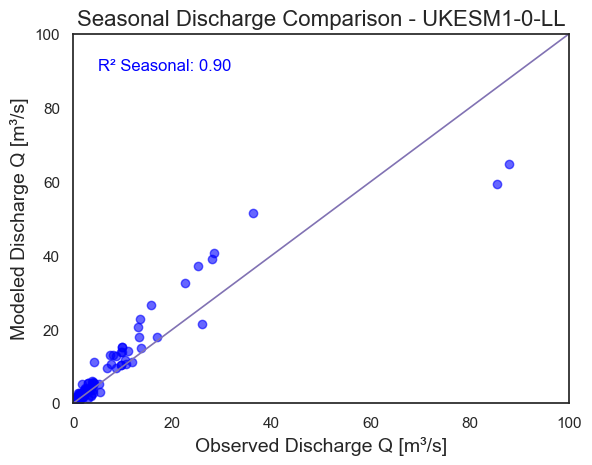

In [10]:
seas_df = model_season_df[model_season_df['season']=='SON']

plt.scatter(seas_df['q_obs'], seas_df['q_model'], label='Q', color='blue', alpha=0.6)

#1:1 line
plt.plot([0, 125], [0, 125], 'm', label='1:1 line', lw=1.2)
plt.xlim(0, 100)
plt.ylim(0, 100)

#r2
r2_season = r2_score(seas_df['q_obs'], seas_df['q_model'])
plt.text(5, 90, f'R² Seasonal: {r2_season:.2f}', fontsize=12, color='blue')
plt.xlabel('Observed Discharge Q [m³/s]', fontsize=14)
plt.ylabel('Modeled Discharge Q [m³/s]', fontsize=14)
plt.title(f'Seasonal Discharge Comparison - {model}', fontsize=16)

# plt.ylim(0, 40)
# plt.xlim(0, 40)

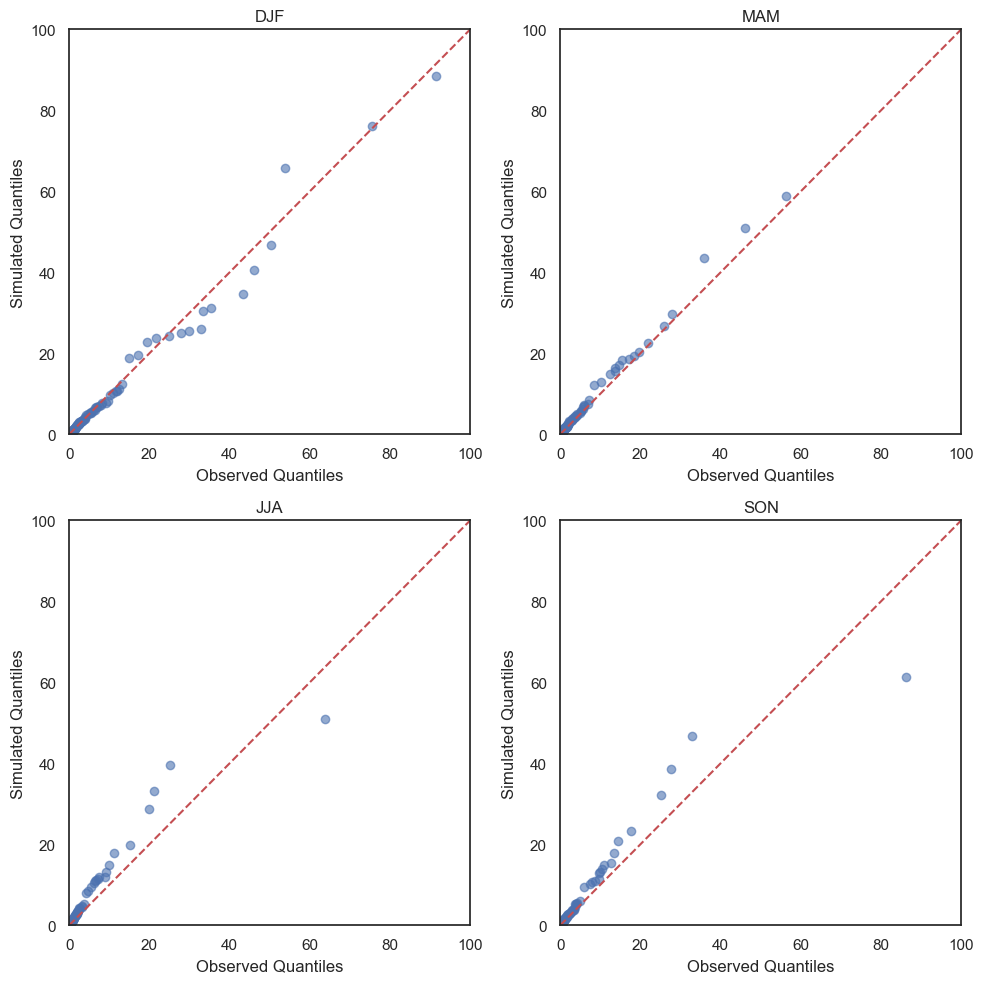

In [11]:
seasons = ["DJF", "MAM", "JJA", "SON"]
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for ax, season in zip(axes.ravel(), seasons):
    obs_season = model_season_df[model_season_df['season'] == season]['q_obs']
    sim_season = model_season_df[model_season_df['season'] == season]['q_model']

    probs = np.linspace(0, 100, 101)  # 0–100 percentiles
    q_obs = np.nanpercentile(obs_season, probs)
    q_sim = np.nanpercentile(sim_season, probs)

    ax.scatter(q_obs, q_sim, alpha=0.6)
    lims = [0, max(q_obs.max(), q_sim.max())]
    ax.plot(lims, lims, 'r--')
    ax.set_title(season)
    ax.set_xlabel("Observed Quantiles")
    ax.set_ylabel("Simulated Quantiles")
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
plt.tight_layout()
